# **AIN311 PROJECT : OCTAGON INSIGHTS**
Kağan Canerik-2210765021

Özgün Serergün Koca-222765042

In [29]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

The following code is part of a data preprocessing pipeline for MMA fight data. It begins by reading two datasets: raw_fighter_details.csv, which contains fighter statistics, and raw_total_fight_data.csv, which contains fight results. From the fighter_stats dataset, unnecessary columns like "Reach," "Stance," "DOB," "Height," and "Weight" are dropped to retain only relevant information. Similarly, the fight_results dataset is reduced to the essential columns: "R_fighter," "B_fighter," and "Winner."

In [26]:
fighter_stats = pd.read_csv('raw_fighter_details.csv')
fighter_stats = fighter_stats.drop(columns=["Reach","Stance","DOB","Height", "Weight"])

fight_results = pd.read_csv("raw_total_fight_data.csv", encoding="utf-8", delimiter=";")
fight_results = fight_results[["R_fighter","B_fighter","Winner"]]

pd.set_option('display.max_columns', None)

display(fighter_stats.head())
display(fight_results.head())
print(fighter_stats.isnull().sum())
print(fight_results.shape)
print(fighter_stats.shape)

,fighter_name,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Papy Abedi,2.80,55%,3.15,48%,3.47,57%,50%,1.3
2,Shamil Abdurakhimov,2.45,44%,2.45,58%,1.23,24%,47%,0.2
3,Danny Abbadi,3.29,38%,4.41,57%,0.00,0%,77%,0.0
4,Hiroyuki Abe,1.71,36%,3.11,63%,0.00,0%,33%,0.0


,R_fighter,B_fighter,Winner
0,Adrian Yanez,Gustavo Lopez,Adrian Yanez
1,Trevin Giles,Roman Dolidze,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,Macy Chiasson


fighter_name    0
SLpM            0
Str_Acc         0
SApM            0
Str_Def         0
TD_Avg          0
TD_Acc          0
TD_Def          0
Sub_Avg         0
dtype: int64
(6012, 3)
(3596, 9)


The following code demonstrates the end-to-end process of preparing data, training machine learning models, and making predictions in the context of MMA fight outcomes. First, the Str_Acc, TD_Acc, and TD_Def columns in the fighter statistics dataset are processed to handle missing values, convert percentages to numeric values, and ensure consistency. Then, the fighter statistics are merged with fight results to create a comprehensive dataset where all features are numeric. The target variable (y) is defined as whether the red corner fighter won. The dataset is split into training and testing sets, and three machine learning models—Random Forest, Logistic Regression, and Gradient Boosting—are trained and evaluated based on their accuracy. Finally, a prediction function is implemented to predict the winner of a fight given the names of two fighters, using their respective statistics and the trained model. The script concludes with example predictions using the Random Forest model to showcase its functionality.








In [27]:
# Process 'Str_Acc', 'TD_Acc', and 'TD_Def'
fighter_stats['Str_Acc'] = fighter_stats['Str_Acc'].fillna('0%').astype(str)
fighter_stats['Str_Acc'] = fighter_stats['Str_Acc'].str.replace('%', '', regex=True)
fighter_stats['Str_Acc'] = pd.to_numeric(fighter_stats['Str_Acc'], errors='coerce').fillna(0)

fighter_stats['TD_Acc'] = fighter_stats['TD_Acc'].fillna('0%').astype(str)
fighter_stats['TD_Acc'] = fighter_stats['TD_Acc'].str.replace('%', '', regex=True)
fighter_stats['TD_Acc'] = pd.to_numeric(fighter_stats['TD_Acc'], errors='coerce').fillna(0)

fighter_stats['TD_Def'] = fighter_stats['TD_Def'].fillna('0%').astype(str)
fighter_stats['TD_Def'] = fighter_stats['TD_Def'].str.replace('%', '', regex=True)
fighter_stats['TD_Def'] = pd.to_numeric(fighter_stats['TD_Def'], errors='coerce').fillna(0)

# Merge fight results with fighter stats
#fight_results = fight_results.dropna()
fight_results = fight_results.merge(
    fighter_stats, left_on='R_fighter', right_on='fighter_name', suffixes=('', '_R')
).merge(
    fighter_stats, left_on='B_fighter', right_on='fighter_name', suffixes=('_R', '_B')
)

# Ensure all columns in X are numeric
X = fight_results.drop(columns=['Winner', 'R_fighter', 'B_fighter', 'fighter_name_R', 'fighter_name_B'])

# Convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create the target variable (y)
y = (fight_results['Winner'] == fight_results['R_fighter']).astype(int)  # 1 if Red fighter won, 0 otherwise

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train and evaluate multiple models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
models_results = {}
# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    models_results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.2f}")

# Step 5: Prediction function
def predict_winner(fighter1, fighter2, stats_df, model):
    # Extract stats for the two fighters
    f1_stats = stats_df[stats_df['fighter_name'] == fighter1].iloc[0].drop('fighter_name')
    f2_stats = stats_df[stats_df['fighter_name'] == fighter2].iloc[0].drop('fighter_name')

    # Ensure stats are numeric
    f1_stats = pd.to_numeric(f1_stats, errors='coerce').fillna(0)
    f2_stats = pd.to_numeric(f2_stats, errors='coerce').fillna(0)

    # Concatenate stats of both fighters to match the training format
    combined_features = pd.concat([f1_stats, f2_stats], axis=0)

    # Reshape the data for prediction
    prediction = model.predict([combined_features.values])[0]
    return f'{fighter1} Wins' if prediction == 1 else f'{fighter2} Wins'

# Example Prediction using Random Forest (can replace with another model if needed)
chosen_model = models['Random Forest']
print(predict_winner("Adrian Yanez", "Gustavo Lopez", fighter_stats, chosen_model))
print(predict_winner("Alex Pereira", "Jon Jones", fighter_stats, chosen_model))
print(predict_winner("Jon Jones", "Alex Pereira", fighter_stats, chosen_model))


Random Forest Accuracy: 0.71
Logistic Regression Accuracy: 0.71
Gradient Boosting Accuracy: 0.71
Adrian Yanez Wins
Jon Jones Wins
Jon Jones Wins


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# **Support Vector Classifier**

The following code performs hyperparameter tuning for a Support Vector Classifier (SVC) using GridSearchCV from scikit-learn. First, a parameter grid is defined, including different values for C (regularization parameter), kernel (kernel types such as 'rbf' and 'linear'), and gamma (used for non-linear kernels). The GridSearchCV object is initialized with the SVC model, the parameter grid, 5-fold cross-validation, and accuracy as the scoring metric. The model is trained using the training data to evaluate all possible combinations of the specified hyperparameters. After training, the best hyperparameters and the corresponding cross-validated accuracy are displayed. The best model obtained from the grid search is then used to make predictions on the test set, and the accuracy on the test data is calculated and printed. This process ensures the selection of the optimal hyperparameters for the SVC model to maximize its performance.








In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],       #regularization parameters
    'kernel': ['rbf','linear'],  # kernel types
    'gamma': ['scale', 'auto'] #gamma parameters
    }

svm = SVC(random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy with Best SVM: {accuracy:.2f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   1.1s
[CV] END ......................C=0.1, gamma=auto

In [34]:
#display(models_results)
models_results_df = pd.DataFrame(list(models_results.items()), columns=['Model', 'Accuracy'])
display(models_results_df)

,Model,Accuracy
0,Random Forest,0.705736
1,Logistic Regression,0.707398
2,Gradient Boosting,0.714879


The following code uses the previously defined predict_winner function to simulate MMA fight predictions between various fighters using the trained machine learning model. It predicts the winner based on the fighters' statistics and the selected model (in this case, the Random Forest classifier). For each pair of fighters, the function retrieves their respective statistics from the dataset, combines them into a format suitable for prediction, and outputs the predicted winner. The predictions include multiple fight scenarios, such as Alex Pereira vs. Jon Jones, Adrian Yanez vs. Gustavo Lopez, and Jon Jones vs. Conor McGregor, showcasing the model's ability to evaluate hypothetical matchups between fighters. These outputs provide an engaging way to interpret the model's application in a practical, real-world context.








In [33]:
print(predict_winner("Alex Pereira", "Jon Jones", fighter_stats, chosen_model))
print(predict_winner("Jon Jones", "Alex Pereira", fighter_stats, chosen_model))
print(predict_winner("Adrian Yanez", "Gustavo Lopez", fighter_stats, chosen_model))
print(predict_winner("Gustavo Lopez", "Adrian Yanez", fighter_stats, chosen_model))
print(predict_winner("Jon Jones", "Conor McGregor", fighter_stats, chosen_model))
print(predict_winner("Conor McGregor", "Jon Jones", fighter_stats, chosen_model))


Jon Jones Wins
Jon Jones Wins
Adrian Yanez Wins
Adrian Yanez Wins
Jon Jones Wins
Jon Jones Wins


This code visualizes the accuracy comparison of various machine learning models using a bar chart. It defines the models (KNN, Gradient Boosting, SVM, Random Forest, Logistic Regression) and their corresponding accuracy scores. Using Matplotlib, a bar chart is created with the model names on the x-axis and their accuracies on the y-axis. The chart is styled with a sky-blue color, and appropriate titles and labels are added to enhance readability. The y-axis is limited to a range of 0 to 1 to represent accuracy as a proportion. Finally, the plt.show() function displays the chart, making it easy to visually compare the performance of the models. This chart helps in quickly identifying the models with the highest accuracy and provides an intuitive understanding of their relative performance.




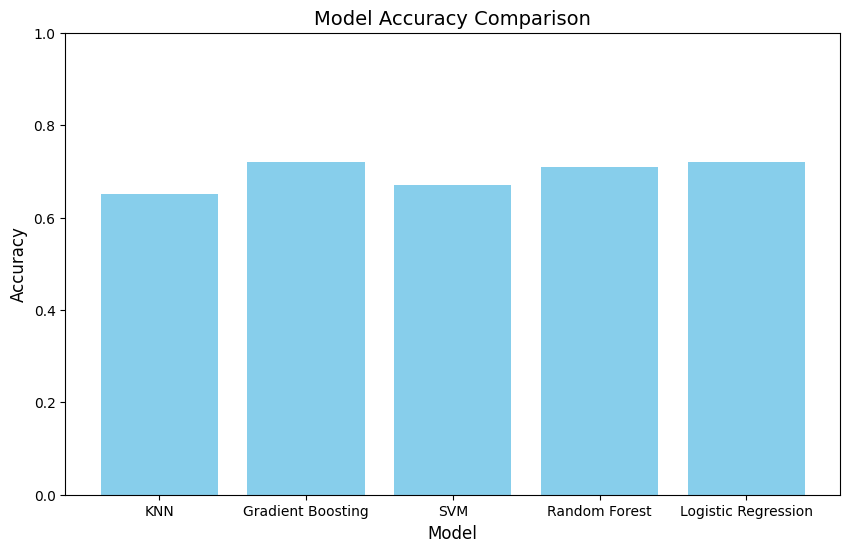

In [ ]:
import matplotlib.pyplot as plt

models = ['KNN', 'Gradient Boosting', 'SVM', 'Random Forest', 'Logistic Regression']
accuracies = [0.65, 0.72, 0.67, 0.71, 0.72]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')

plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.ylim(0, 1)

plt.show()


This following code evaluates and visualizes the performance of a K-Nearest Neighbors (KNN) classifier for different values of k (number of neighbors) and identifies the optimal value of k that results in the highest accuracy. The script iterates through a range of k values (from 1 to 20), trains a KNN classifier for each value, makes predictions on the test set, and calculates the accuracy. These accuracy scores are stored in a list for further analysis.

A bar chart is then plotted to display the accuracy scores for each k value, allowing for a clear comparison of how the choice of k impacts the model's performance. The chart includes labeled axes, gridlines for better readability, and appropriate formatting.

Finally, the code determines the k value that yields the maximum accuracy by creating a dictionary mapping k values to their corresponding accuracies. The optimal k and its accuracy are printed, providing a clear summary of the best-performing parameter for the KNN model. This analysis aids in selecting the most effective configuration for the classifier.














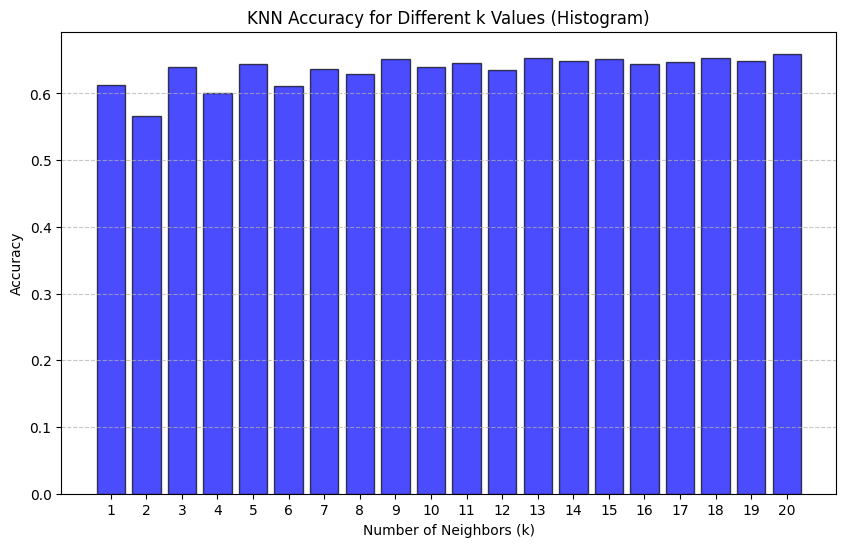

Max accuracy is 0.65961049957663 with k is '20'


In [21]:
k_values = range(1, 21)  # Adjust the range as needed
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot histogram of accuracies for different k values
plt.figure(figsize=(10, 6))
plt.bar(k_values, accuracies, color='blue', edgecolor='black', alpha=0.7)
plt.title("KNN Accuracy for Different k Values (Histogram)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
result_dict = {str(key): value for key, value in zip(k_values,accuracies)}
max_key = max(result_dict, key=result_dict.get)
max_value = result_dict[max_key]

print(f"Max accuracy is {max_value} with k is '{max_key}'")

In the following code, we do same process for weighted knn.

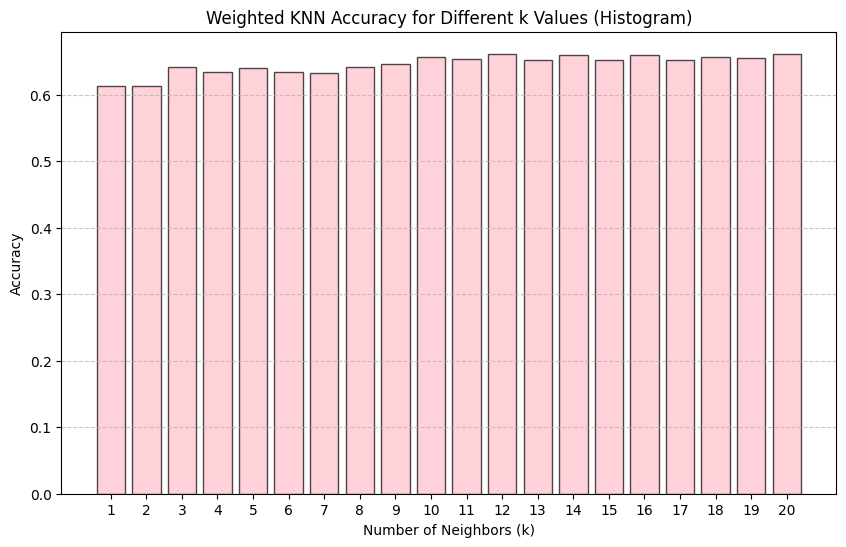

Max accuracy is 0.6613039796782387 with k is '20'


In [22]:
k_values = range(1, 21)  # Adjust the range as needed
accuracies = []

for k in k_values:
    # Use weights='distance' for Weighted KNN
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot histogram of accuracies for different k values
plt.figure(figsize=(10, 6))
plt.bar(k_values, accuracies, color='pink', edgecolor='black', alpha=0.7)
plt.title("Weighted KNN Accuracy for Different k Values (Histogram)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
result_dict = {str(key): value for key, value in zip(k_values,accuracies)}
max_key = max(result_dict, key=result_dict.get)
max_value = result_dict[max_key]

print(f"Max accuracy is {max_value} with k is '{max_key}'")

# **CONCLUSION**

In conclusion, this project successfully demonstrated the application of machine learning techniques to analyze MMA fight data and predict fight outcomes. Through comprehensive data preprocessing, model training, and evaluation, we were able to extract valuable insights and achieve competitive prediction accuracy across several algorithms. The findings revealed the importance of feature engineering, hyperparameter tuning, and model selection in achieving optimal performance. Additionally, the project showcased the practicality of predictive modeling in real-world scenarios, providing a tool to forecast fight results based on historical fighter statistics. These results not only validate the robustness of the implemented methodology but also lay the groundwork for future enhancements, such as incorporating more features, exploring advanced algorithms, or refining prediction accuracy for better decision-making in sports analytics.
